# Projet Neural Network - Corporación Favorita Grocery Sales Forecasting

Brick-and-mortar grocery stores are always in a delicate dance with purchasing and sales forecasting. Predict a little over, and grocers are stuck with overstocked, perishable goods. Guess a little under, and popular items quickly sell out, leaving money on the table and customers fuming.

The problem becomes more complex as retailers add new locations with unique needs, new products, ever transitioning seasonal tastes, and unpredictable product marketing. Corporación Favorita, a large Ecuadorian-based grocery retailer, knows this all too well. They operate hundreds of supermarkets, with over 200,000 different products on their shelves.

Corporación Favorita has challenged the Kaggle community to build a model that more accurately forecasts product sales. They currently rely on subjective forecasting methods with very little data to back them up and very little automation to execute plans. They’re excited to see how machine learning could better ensure they please customers by having just enough of the right products at the right time.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import random as rd
from tqdm import tqdm
import pandas as pd
import os
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from seasonal import *
from statsmodels.tsa.tsatools import *
from statsmodels.tsa.stattools import *
from statsmodels.tsa.tsatools import detrend
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error

from neural_network import neural_net_model, neural_net_model_3layers, rnn_model

Using TensorFlow backend.


In [2]:
# Refer to the py file: "processing_data.py"
from processing_data import preprocessing

# One shop forecast

## I - Imports

/Users/louisgiron/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
/Users/louisgiron/Desktop/ENSAE - Mastère spé/Reseaux de neurones/projet_nn/processing_data.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  train_small['unit_sales'] = train_small['unit_sales'].apply(lambda x:


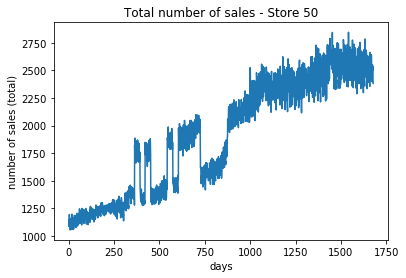

In [3]:
n = None
store_selection = 'yes'

train_all, test = preprocessing(n, store_selection)

# We are studying only one store, so the information about the city, the
# region are useless
train_all = train_all.drop(['id', 'store_nbr', 'city', 'state',
                       'cluster', 'type_x'], axis=1)
train_all = train_all.set_index('date')

In [4]:
print('Train - heads:')
print(train_all.head())
print()
print('---')
print('Train - shape:')
print(train_all.shape)

Train - heads:
            item_nbr  unit_sales onpromotion  dcoilwtico type_y locale  \
date                                                                     
2013-01-02    103665         6.0         NaN       93.14    NaN    NaN   
2013-01-02    105574        16.0         NaN       93.14    NaN    NaN   
2013-01-02    105575        38.0         NaN       93.14    NaN    NaN   
2013-01-02    105693         7.0         NaN       93.14    NaN    NaN   
2013-01-02    105737        16.0         NaN       93.14    NaN    NaN   

           locale_name description transferred        family  class  \
date                                                                  
2013-01-02         NaN         NaN         NaN  BREAD/BAKERY   2712   
2013-01-02         NaN         NaN         NaN     GROCERY I   1045   
2013-01-02         NaN         NaN         NaN     GROCERY I   1045   
2013-01-02         NaN         NaN         NaN     GROCERY I   1034   
2013-01-02         NaN         NaN      

## II - Preprocessing of the data

### A - Missing data

In [5]:
# Explore and manage the missing data
print('Before missing values management:')
print('----')
missing = train_all.apply(lambda x: x.isnull().sum(), axis=0)
missing = pd.DataFrame(missing)
missing.columns = ["Number of missing values"]

# Share of missing
missing['Share of missing'] = round(missing['Number of missing values']/len(train_all)*100,2)
print(missing)

missing_rate = {}
for col in train_all.columns:
    missing_rate[col] = np.sum(train_all[col].isna())/len(train_all[col])

missing_rate_lim = 0.7

for key in missing_rate.keys():
    if missing_rate[key] > missing_rate_lim:
        train_all = train_all.drop([key], axis=1)

    if 0 < missing_rate[key] < missing_rate_lim:
        # Handle missing values - Use the mean strategy
        imp = SimpleImputer(missing_values=np.nan, strategy='mean')
        imp.fit(np.array(train_all[key]).reshape(-1, 1))
        temp_no_miss = imp.transform(np.array(train_all[key]).reshape(-1, 1))
        train_all[key] = temp_no_miss

print()
print('After missing values management:')
print('----')
# After the management
missing = train_all.apply(lambda x: x.isnull().sum(), axis=0)
missing = pd.DataFrame(missing)
missing.columns = ["Number of missing values"]

# Share of missing
missing['Share of missing'] = round(missing['Number of missing values']/len(train_all)*100,2)
print(missing)

Before missing values management:
----
              Number of missing values  Share of missing
item_nbr                             0              0.00
unit_sales                           0              0.00
onpromotion                     587129             18.39
dcoilwtico                     1031727             32.32
type_y                         2700859             84.60
locale                         2700859             84.60
locale_name                    2700859             84.60
description                    2700859             84.60
transferred                    2700859             84.60
family                               0              0.00
class                                0              0.00
perishable                           0              0.00
transactions                      4848              0.15

After missing values management:
----
              Number of missing values  Share of missing
item_nbr                             0               0.0
unit_sales

In [6]:
print('Train - heads:')
print(train_all.head())
print()
print('---')
print('Train - shape:')
print(train_all.shape)

Train - heads:
            item_nbr  unit_sales  onpromotion  dcoilwtico        family  \
date                                                                      
2013-01-02    103665         6.0     0.066828       93.14  BREAD/BAKERY   
2013-01-02    105574        16.0     0.066828       93.14     GROCERY I   
2013-01-02    105575        38.0     0.066828       93.14     GROCERY I   
2013-01-02    105693         7.0     0.066828       93.14     GROCERY I   
2013-01-02    105737        16.0     0.066828       93.14     GROCERY I   

            class  perishable  transactions  
date                                         
2013-01-02   2712           1        3077.0  
2013-01-02   1045           0        3077.0  
2013-01-02   1045           0        3077.0  
2013-01-02   1034           0        3077.0  
2013-01-02   1044           0        3077.0  

---
Train - shape:
(3192566, 8)


### B - Categorical Variables

In [7]:
# Categorical variables
# family is a category
family = train_all[['family', 'unit_sales']]
family = family.groupby(['family'], as_index=False)['unit_sales'].count()
family.columns = ['family', 'count']
family['repartition_percent'] = family['count']/np.sum(family['count'])*100
family = family.sort_values(by=['count'], ascending=False)
family.reset_index(inplace=True)
family = family.drop('index', axis=1)
print(family)

selection = list(family['family'].loc[:3])

# Nous gardons les 4 premieres categories (choix arbitraire) et créeons une catégorie other
def family_transform(x, selection=selection):
    if x in selection:
        return x
    else:
        return 'other'


train_all['family'] = train_all['family'].apply(family_transform)
train_all = pd.get_dummies(train_all)

print(train_all.columns)

                        family    count  repartition_percent
0                    GROCERY I  1121336            35.123346
1                    BEVERAGES   436659            13.677368
2                     CLEANING   411815            12.899185
3                        DAIRY   229998             7.204174
4                      PRODUCE   210027             6.578627
5                 BREAD/BAKERY   118620             3.715507
6                PERSONAL CARE   115635             3.622008
7                         DELI   103318             3.236206
8                        MEATS    75309             2.358886
9                    HOME CARE    65143             2.040459
10                     POULTRY    52313             1.638588
11                FROZEN FOODS    45685             1.430981
12                        EGGS    40457             1.267225
13            LIQUOR,WINE,BEER    30073             0.941970
14              PREPARED FOODS    20482             0.641553
15          HOME AND KIT

### C - Data Set transformation

#### Transform the time series in handling dataset

In [8]:
def series_to_supervised(data, shift_window_past, value_to_predict, shift_window_future=0):
    """
    Input:
    -----
    data: Pandas DF
    shift_window_past: number of shifts in the past
    shift_window_future: 
    """
    name_var = data.columns
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(shift_window_past, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (name, i)) for name in name_var]
        
    # Value to predict at t
    val = data[value_to_predict]
    cols.append(val)
    names.append(str(value_to_predict) + '(t)')
    
    if shift_window_future > 0:
        # forecast sequence (t, t+1, ... t+n)
        for i in range(1, shift_window_future+1):
            cols.append(data.shift(-i))
            if i == 0:
                names += [('%s(t)' % (name)) for name in name_var]
            else:
                names += [('%s(t+%d)' % (name, i)) for name in name_var]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values (erase the first shift_window_past rows)
    agg.dropna(inplace=True)
    return agg

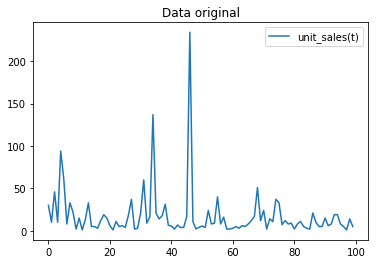

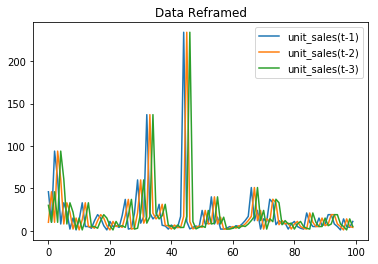

In [9]:
# load dataset
dataset = train_all.copy()

# ensure all data is float
dataset = dataset.astype('float32')

# frame as supervised learning
shift_window_past = 3
value_to_predict = 'unit_sales'
shift_window_future=0
reframed = series_to_supervised(dataset, shift_window_past, value_to_predict, shift_window_future=0)

# Visualisation
plt.figure()
plt.plot(list(dataset['unit_sales'])[500:600], label='unit_sales(t)')
plt.title('Data original')
plt.legend()
plt.show()

plt.figure()
for i in range(1, shift_window_past+1):
    plt.plot(list(reframed[('unit_sales(t-%d)' % (i))])[500:600], label=('unit_sales(t-%d)' % (i)))
plt.title('Data Reframed')
plt.legend()
plt.show()

In [10]:
reframed.head()

,item_nbr(t-3),unit_sales(t-3),onpromotion(t-3),dcoilwtico(t-3),class(t-3),perishable(t-3),transactions(t-3),family_BEVERAGES(t-3),family_CLEANING(t-3),family_DAIRY(t-3),...,dcoilwtico(t-1),class(t-1),perishable(t-1),transactions(t-1),family_BEVERAGES(t-1),family_CLEANING(t-1),family_DAIRY(t-1),family_GROCERY I(t-1),family_other(t-1),unit_sales(t)
date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,103665.0,6.0,0.066828,93.139999,2712.0,1.0,3077.0,0.0,0.0,0.0,...,93.139999,1045.0,0.0,3077.0,0.0,0.0,0.0,1.0,0.0,7.0
2013-01-02,105574.0,16.0,0.066828,93.139999,1045.0,0.0,3077.0,0.0,0.0,0.0,...,93.139999,1034.0,0.0,3077.0,0.0,0.0,0.0,1.0,0.0,16.0
2013-01-02,105575.0,38.0,0.066828,93.139999,1045.0,0.0,3077.0,0.0,0.0,0.0,...,93.139999,1044.0,0.0,3077.0,0.0,0.0,0.0,1.0,0.0,12.0
2013-01-02,105693.0,7.0,0.066828,93.139999,1034.0,0.0,3077.0,0.0,0.0,0.0,...,93.139999,1092.0,0.0,3077.0,0.0,0.0,0.0,1.0,0.0,9.0
2013-01-02,105737.0,16.0,0.066828,93.139999,1044.0,0.0,3077.0,0.0,0.0,0.0,...,93.139999,1032.0,0.0,3077.0,0.0,0.0,0.0,1.0,0.0,9.0


In [11]:
print('Original set shape:')
print('----')
print(dataset.shape)
print()
print('Reframed set shape: (with shift_window = ' + str(shift_window_past) + ')')
print('----')
print(reframed.shape)

Original set shape:
----
(3192566, 12)

Reframed set shape: (with shift_window = 3)
----
(3192563, 37)


### D - Fearture importance

In [12]:
# Feature importance
X = reframed.drop(['unit_sales(t)'], axis=1).copy()
y = reframed['unit_sales(t)'].copy()

features = X.columns

print('Shape of X:', X.shape)
print('Shape of y:', y.shape)

Shape of X: (3192563, 36)
Shape of y: (3192563,)


In [13]:
# Model Lasso for feature selection
clf = LassoCV(cv=5)
clf = clf.fit(np.array(X), np.array(y))

/Users/louisgiron/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/louisgiron/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/louisgiron/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/louisgiron/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: 

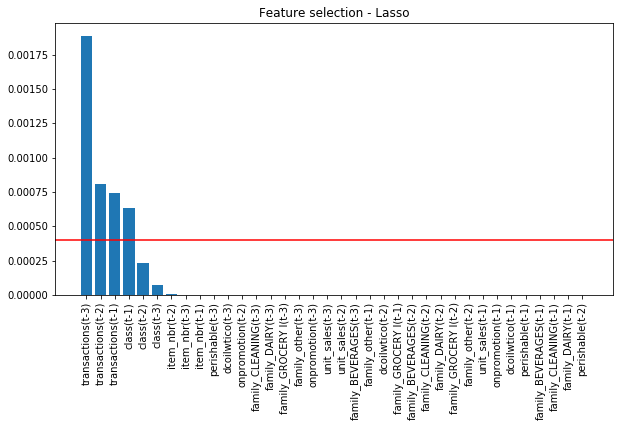

In [14]:
# Visualisation of the result
res_lasso = np.abs(clf.coef_)
index_sort = np.argsort(res_lasso)[::-1]

feature_sort = list(features[index_sort])
res_lasso_sort = res_lasso[index_sort]
lim_feature_imp = 0.0004

fig = plt.figure(figsize=(10, 5))
plt.bar(np.arange(0, len(feature_sort)), res_lasso_sort)
plt.axhline(y=lim_feature_imp, color='r', linestyle='-')
plt.xticks(np.arange(0, len(feature_sort)), feature_sort, rotation='vertical')
plt.title('Feature selection - Lasso')
plt.show()

In [15]:
# Treshold
treshold = 0

model = SelectFromModel(clf, threshold=treshold, prefit=True)
feature_selected_index = model.get_support(indices=True)

print('Feature selected:')
print(features[feature_selected_index])

# selection
value_to_predict = 'unit_sales(t)'
selection = list(features[feature_selected_index])
selection.append(value_to_predict)

Feature selected:
Index(['item_nbr(t-3)', 'unit_sales(t-3)', 'onpromotion(t-3)',
       'dcoilwtico(t-3)', 'class(t-3)', 'perishable(t-3)', 'transactions(t-3)',
       'family_BEVERAGES(t-3)', 'family_CLEANING(t-3)', 'family_DAIRY(t-3)',
       'family_GROCERY I(t-3)', 'family_other(t-3)', 'item_nbr(t-2)',
       'unit_sales(t-2)', 'onpromotion(t-2)', 'dcoilwtico(t-2)', 'class(t-2)',
       'perishable(t-2)', 'transactions(t-2)', 'family_BEVERAGES(t-2)',
       'family_CLEANING(t-2)', 'family_DAIRY(t-2)', 'family_GROCERY I(t-2)',
       'family_other(t-2)', 'item_nbr(t-1)', 'unit_sales(t-1)',
       'onpromotion(t-1)', 'dcoilwtico(t-1)', 'class(t-1)', 'perishable(t-1)',
       'transactions(t-1)', 'family_BEVERAGES(t-1)', 'family_CLEANING(t-1)',
       'family_DAIRY(t-1)', 'family_GROCERY I(t-1)', 'family_other(t-1)'],
      dtype='object')


### E - Final train set

In [16]:
train_all_processed = reframed[selection]

print('X train original shape:', reframed.shape)
print('X train processed shape:', train_all_processed.shape)

X train original shape: (3192563, 37)
X train processed shape: (3192563, 37)


## III - Training setup

In [17]:
# Train size
value_to_predict = 'unit_sales(t)'
train_size_ratio = 0.6
valid_train_size_ratio = 0.1

# Normalize train X
data_X = train_all_processed.drop([value_to_predict], axis=1)
data_y = train_all_processed[value_to_predict]

scaler = MinMaxScaler(feature_range=(0, 1))
data_X_norm = scaler.fit_transform(data_X)
data_y_norm = scaler.fit_transform(np.array(data_y).reshape(-1, 1))

# Definition of train, valid and test
size = train_all_processed.shape[0]

train_set = np.arange(0, int(train_size_ratio*size))
valid_set = np.arange(int(train_size_ratio*size), int(train_size_ratio*size)
                      + int(valid_train_size_ratio*size))
test_set = np.arange(int(train_size_ratio*size+valid_train_size_ratio*size),
                     int(size))

# Split the train data to learn # Warning date -> split linearly
X_train = data_X_norm[train_set, :]
y_train = data_y_norm[train_set]
X_valid = data_X_norm[valid_set, :]
y_valid = data_y_norm[valid_set]
X_test = data_X_norm[test_set, :]
y_test = data_y_norm[test_set]

print('X train shape:', X_train.shape)
print('X valid shape:', X_valid.shape)
print('X test shape:', X_test.shape)

def denormalize(y_train, norm_data):
    try:
        df = y_train.values.reshape(-1, 1)
    except AttributeError:
        df = y_train.reshape(-1, 1)
    norm_data = norm_data.reshape(-1, 1)
    scl = MinMaxScaler()
    scl.fit_transform(df)
    return scl.inverse_transform(norm_data)

/Users/louisgiron/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


X train shape: (1915537, 36)
X valid shape: (319256, 36)
X test shape: (957769, 36)


## IV - 2 layers neural network

### A - Model initialization

In [18]:
# Input data
nb_epoch = 20
nb_input = X_train.shape[1]
nb_hidden1 = 10
nb_hidden2 = 6
batch_size = 1000

# Initialize the model
X_tf = tf.placeholder(tf.float32)
y_tf = tf.placeholder(tf.float32)
keep_prob_1 = tf.placeholder(tf.float32)
keep_prob_2 = tf.placeholder(tf.float32)

output = neural_net_model(X_tf, nb_input, nb_hidden1, nb_hidden2, keep_prob_1, keep_prob_2)
avg_cost_v = []
c_t = []
c_valid = []
l_rate_v = []

# Drop out level
prob_1 = 0.8
prob_2 = 0.8

cost = tf.reduce_mean(tf.square(output-y_tf))
'''
# Piecewise constant
min_lr = 0.1
max_lr = 0.5
nb_values = nb_epoch

global_step = tf.Variable(0, trainable=False)
boundaries = list(np.linspace(batch_size,
                              batch_size*nb_epoch, nb_values,
                              dtype=np.int32)[:-1])
values = list(np.round(np.linspace(max_lr, min_lr, nb_values), 2))
learning_rate = tf.train.piecewise_constant(global_step, boundaries, values)

j = 0
# Passing global_step to minimize() will increment it at each step.
learning_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost,
                                                                 global_step=global_step)'''

# Exponential decay of the learning rate
global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 0.1
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           int(X_train.shape[0]/batch_size),
                                           0.96, staircase=True)
# Passing global_step to minimize() will increment it at each step.
learning_step = (
    tf.train.AdamOptimizer(learning_rate).minimize(cost,
                                                   global_step=global_step))
j = 0

### B - Model training

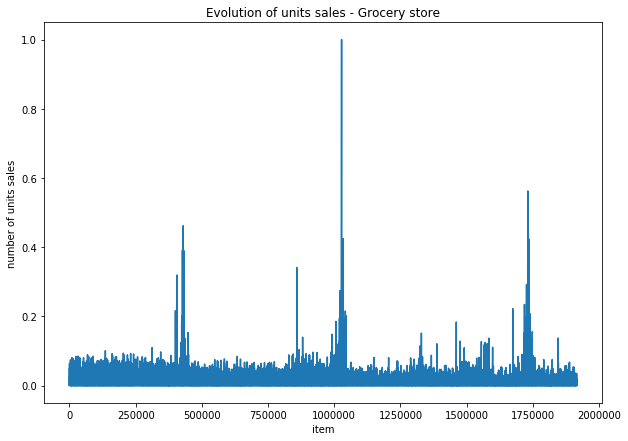

In [19]:
# Initial plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(1, 1, 1)
plt.xlabel('item')
plt.ylabel('number of units sales')
plt.title('Evolution of units sales - Grocery store')
ax.plot(range(len(y_train)), y_train, label='Original')
plt.show()

In [20]:
# Training
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    saver = tf.train.Saver()
    y_t = y_train
    '''try:
        saver.restore(sess, 'NN_favorita_grocery_sales.ckpt')
    except Exception:
        pass'''

    for epoch in tqdm(range(nb_epoch)):

        # Create the batches
        total_batch = int(X_train.shape[0]/batch_size)

        # Run training on batch
        for i in range(total_batch):
            avg_cost = 0.
            # Increment the learning rate with exponential decay
            l_rate = sess.run([learning_rate], {global_step: j})
            l_rate_v.append(l_rate)
            j += 1

            batch_X = X_train[i*batch_size:(i+1)*batch_size]
            batch_y = y_train[i*batch_size:(i+1)*batch_size]

            # Run the train
            _, c = sess.run([learning_step, cost],
                            feed_dict={X_tf: batch_X, y_tf: batch_y,
                                       keep_prob_1: prob_1,
                                       keep_prob_2: prob_2})
            # Compute average cost on train set
            c_t.append(c)
            avg_cost += c / total_batch
        avg_cost_v.append(avg_cost)
        
        # Compute the cost on valid set
        pred, cost_valid = sess.run([output, cost],
                                    feed_dict={X_tf: X_valid,
                                               y_tf: y_valid,
                                               keep_prob_1: 1.0,
                                               keep_prob_2: 1.0})
        c_valid.append(cost_valid)

        print('Epoch :', epoch+1, 'Cost train:', avg_cost_v[epoch], 'Cost valid:', c_valid[epoch],
              'Learning rate:', l_rate)

    # Compute the cost on test set
    print('Cost - Test phase:', sess.run(cost, feed_dict={X_tf: X_test,
                                                          y_tf: y_test,
                                                          keep_prob_1: 1.0,
                                                          keep_prob_2: 1.0}))
    pred_test_norm = sess.run(output, feed_dict={X_tf: X_test,
                                                 keep_prob_1: 1.0,
                                                 keep_prob_2: 1.0})
    pred_test = denormalize(data_y, pred_test_norm)

    '''
    # Save the model
    if input('Save model ? [Y/N]') == 'Y':
        import os
        saver.save(sess, os.getcwd() +
                   '/nn_saved_sessions/NN_favorita_grocery_sales.ckpt')
        print('Model Saved')'''

    # Close the session
    sess.close()

  5%|▌         | 1/20 [00:02<00:40,  2.15s/it]

Epoch : 1 Cost train: 2.010121733584264e-09 Cost valid: 6.843249e-06 Learning rate: [0.1]


 10%|█         | 2/20 [00:04<00:38,  2.13s/it]

Epoch : 2 Cost train: 2.108473968208833e-09 Cost valid: 6.3783305e-06 Learning rate: [0.096]


 15%|█▌        | 3/20 [00:06<00:35,  2.10s/it]

Epoch : 3 Cost train: 1.6853973362853206e-09 Cost valid: 6.3834236e-06 Learning rate: [0.09216]


 20%|██        | 4/20 [00:08<00:33,  2.08s/it]

Epoch : 4 Cost train: 1.8243454487151747e-09 Cost valid: 6.711646e-06 Learning rate: [0.088473596]


 25%|██▌       | 5/20 [00:10<00:31,  2.10s/it]

Epoch : 5 Cost train: 8.639441675436014e-09 Cost valid: 1.3959825e-05 Learning rate: [0.084934644]


 30%|███       | 6/20 [00:12<00:29,  2.11s/it]

Epoch : 6 Cost train: 8.052666089497507e-09 Cost valid: 1.0339989e-05 Learning rate: [0.08153726]


 35%|███▌      | 7/20 [00:14<00:27,  2.10s/it]

Epoch : 7 Cost train: 6.728375313241842e-09 Cost valid: 8.084981e-06 Learning rate: [0.07827577]


 40%|████      | 8/20 [00:16<00:25,  2.09s/it]

Epoch : 8 Cost train: 6.447011847614357e-09 Cost valid: 7.706037e-06 Learning rate: [0.07514474]


 45%|████▌     | 9/20 [00:18<00:22,  2.08s/it]

Epoch : 9 Cost train: 6.104244903920282e-09 Cost valid: 7.3326646e-06 Learning rate: [0.07213895]


 50%|█████     | 10/20 [00:20<00:20,  2.09s/it]

Epoch : 10 Cost train: 5.098350412806851e-09 Cost valid: 6.710873e-06 Learning rate: [0.069253385]


 55%|█████▌    | 11/20 [00:22<00:18,  2.09s/it]

Epoch : 11 Cost train: 3.880980831048726e-09 Cost valid: 6.395623e-06 Learning rate: [0.06648325]


 60%|██████    | 12/20 [00:25<00:16,  2.11s/it]

Epoch : 12 Cost train: 2.9195981504767645e-09 Cost valid: 6.417446e-06 Learning rate: [0.063823916]


 65%|██████▌   | 13/20 [00:27<00:14,  2.10s/it]

Epoch : 13 Cost train: 2.480696904407352e-09 Cost valid: 6.5137383e-06 Learning rate: [0.06127096]


 70%|███████   | 14/20 [00:29<00:12,  2.12s/it]

Epoch : 14 Cost train: 2.2759086182815152e-09 Cost valid: 6.581685e-06 Learning rate: [0.058820125]


 75%|███████▌  | 15/20 [00:31<00:10,  2.15s/it]

Epoch : 15 Cost train: 2.148182079449476e-09 Cost valid: 6.6359094e-06 Learning rate: [0.056467313]


 80%|████████  | 16/20 [00:33<00:08,  2.13s/it]

Epoch : 16 Cost train: 2.023839430826383e-09 Cost valid: 6.688138e-06 Learning rate: [0.054208618]


 85%|████████▌ | 17/20 [00:35<00:06,  2.13s/it]

Epoch : 17 Cost train: 1.892089268436422e-09 Cost valid: 6.7352635e-06 Learning rate: [0.052040275]


 90%|█████████ | 18/20 [00:37<00:04,  2.12s/it]

Epoch : 18 Cost train: 1.792196235803379e-09 Cost valid: 6.7692054e-06 Learning rate: [0.04995866]


 95%|█████████▌| 19/20 [00:39<00:02,  2.11s/it]

Epoch : 19 Cost train: 1.699812471109452e-09 Cost valid: 6.7905157e-06 Learning rate: [0.047960315]


100%|██████████| 20/20 [00:42<00:00,  2.11s/it]

Epoch : 20 Cost train: 1.657059214879727e-09 Cost valid: 6.713253e-06 Learning rate: [0.046041902]


Cost - Test phase: 1.245537e-05


### C - Visualisation

#### Cost of the prediction

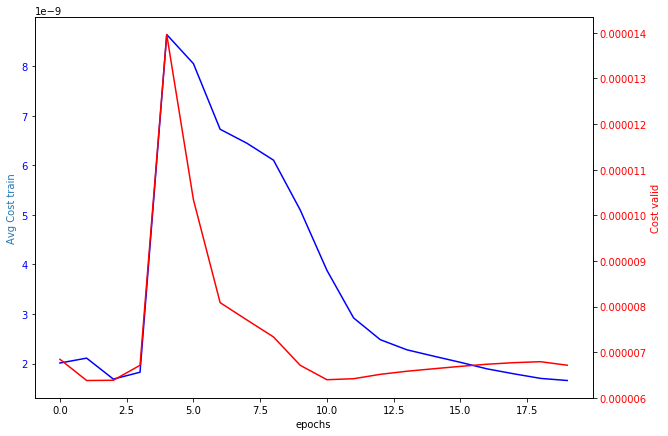

In [21]:
# Plot the costs
fig, ax1 = plt.subplots(figsize=(10, 7))
x = np.arange(nb_epoch)
ax1.plot(x, avg_cost_v, 'b-')
ax1.set_xlabel('epochs')
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('Avg Cost train', color='C0')
for tl in ax1.get_yticklabels():
    tl.set_color('b')


ax2 = ax1.twinx()
ax2.plot(x, c_valid, 'r-')
ax2.set_ylabel('Cost valid', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')  
plt.show()

#### Learning rate through epochs

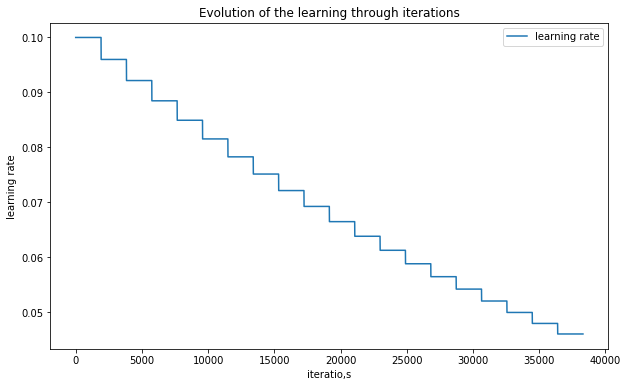

In [22]:
# Plot the learning rate
plt.figure(figsize=(10, 6))
plt.plot(l_rate_v, label="learning rate")
plt.legend(loc='best')
plt.ylabel('learning rate')
plt.xlabel('iteratio,s')
plt.title('Evolution of the learning through iterations')
plt.show()

#### Normalized predictions against normalized original values
Use to check whether the denormalization process is consistent

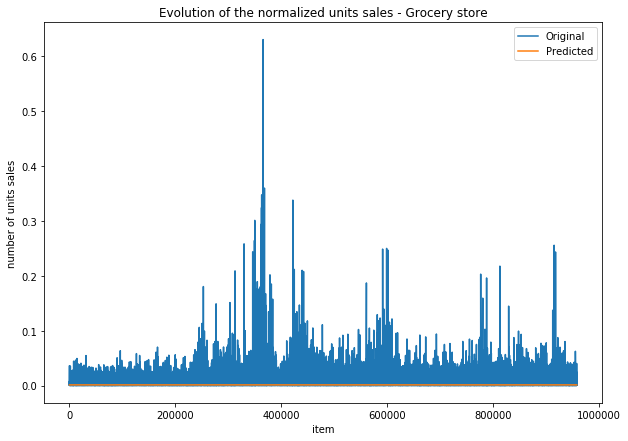

In [23]:
# Plot normalized predictions vs normalized original
fig = plt.figure(figsize=(10, 7))
plt.plot(y_test, label='Original')
plt.plot(pred_test_norm, label='Predicted')
plt.xlabel('item')
plt.ylabel('number of units sales')
plt.legend(loc='best')
plt.title('Evolution of the normalized units sales - Grocery store')
plt.show()

#### Predictions against original values

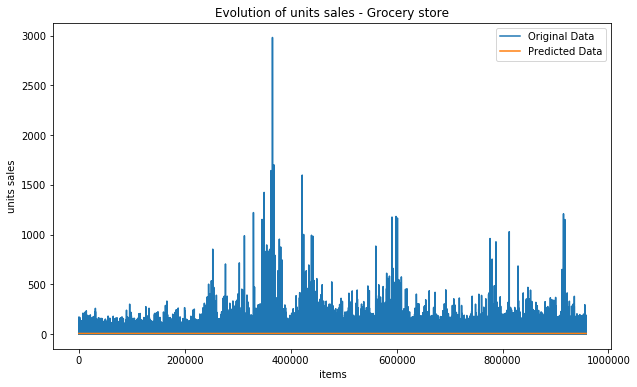

In [24]:
# Plot the prediction vs the original
plt.figure(figsize=(10, 6))
plt.plot(range(y_test.shape[0]), denormalize(data_y, y_test), label="Original Data")
plt.plot(range(y_test.shape[0]), pred_test, label="Predicted Data")
plt.legend(loc='best')
plt.ylabel('units sales')
plt.xlabel('items')
plt.title('Evolution of units sales - Grocery store')
plt.show()

#### Predictions only
Use to observe more precisely the predictions

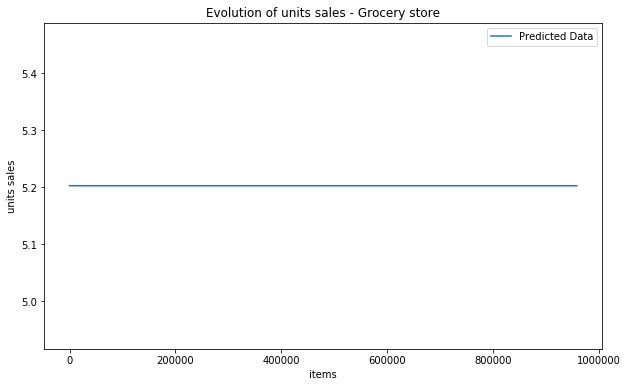

In [25]:
# Plot the prediction vs the original
plt.figure(figsize=(10, 6))
plt.plot(range(y_test.shape[0]), pred_test, label="Predicted Data")
plt.legend(loc='best')
plt.ylabel('units sales')
plt.xlabel('items')
plt.title('Evolution of units sales - Grocery store')
plt.show()

## V - 3 layers neural network

### A - Model initialization

In [26]:
# Input data
nb_epoch = 20
nb_input = X_train.shape[1]
nb_hidden1 = 12
nb_hidden2 = 8
nb_hidden3 = 4
batch_size = 1000

# Initialize the model
X_tf = tf.placeholder(tf.float32)
y_tf = tf.placeholder(tf.float32)
keep_prob_1 = tf.placeholder(tf.float32)
keep_prob_2 = tf.placeholder(tf.float32)
keep_prob_3 = tf.placeholder(tf.float32)

output = neural_net_model_3layers(X_tf, nb_input, nb_hidden1, nb_hidden2, nb_hidden3,
                                  keep_prob_1, keep_prob_2, keep_prob_3)
avg_cost_v = []
c_t = []
c_valid = []
l_rate_v = []

# Drop out level
prob_1 = 0.7
prob_2 = 0.8
prob_3 = 0.9

cost = tf.reduce_mean(tf.square(output-y_tf))
'''
# Piecewise constant
min_lr = 0.1
max_lr = 0.5
nb_values = nb_epoch

global_step = tf.Variable(0, trainable=False)
boundaries = list(np.linspace(batch_size,
                              batch_size*nb_epoch, nb_values,
                              dtype=np.int32)[:-1])
values = list(np.round(np.linspace(max_lr, min_lr, nb_values), 2))
learning_rate = tf.train.piecewise_constant(global_step, boundaries, values)

j = 0
# Passing global_step to minimize() will increment it at each step.
learning_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost,
                                                                 global_step=global_step)'''

# Exponential decay of the learning rate
global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 0.1
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           int(X_train.shape[0]/batch_size),
                                           0.96, staircase=True)
# Passing global_step to minimize() will increment it at each step.
learning_step = (
    tf.train.AdamOptimizer(learning_rate).minimize(cost,
                                                   global_step=global_step))
j = 0

### B - Model training

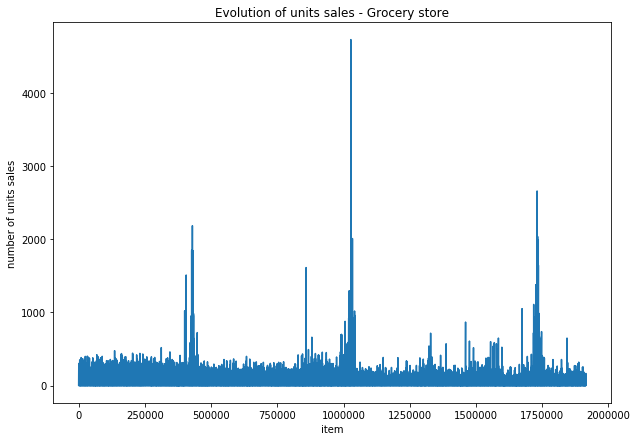

In [27]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(1, 1, 1)
plt.xlabel('item')
plt.ylabel('number of units sales')
plt.title('Evolution of units sales - Grocery store')
ax.plot(range(len(y_train)), denormalize(data_y, y_train), label='Original')
plt.show()

In [28]:
# Training
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    saver = tf.train.Saver()
    y_t = denormalize(data_y, y_train)

    '''try:
        saver.restore(sess, 'NN_favorita_grocery_sales.ckpt')
    except Exception:
        pass'''

    for epoch in tqdm(range(nb_epoch)):

        # Create the batches
        total_batch = int(X_train.shape[0]/batch_size)

        # Run training on batch
        for i in range(total_batch):
            avg_cost = 0.
            # Increment the learning rate with exponential decay
            l_rate = sess.run([learning_rate], {global_step: j})
            l_rate_v.append(l_rate)
            j += 1

            batch_X = X_train[i*batch_size:(i+1)*batch_size]
            batch_y = y_train[i*batch_size:(i+1)*batch_size]

            # Run the train
            _, c = sess.run([learning_step, cost],
                            feed_dict={X_tf: batch_X, y_tf: batch_y,
                                       keep_prob_1: prob_1,
                                       keep_prob_2: prob_2,
                                       keep_prob_3: prob_3})
            # Compute average cost on the train set
            c_t.append(c)
            avg_cost += c / total_batch
        avg_cost_v.append(avg_cost)
        
        # Compute the cost on the valid set
        pred_norm, cost_valid = sess.run([output, cost],
                                         feed_dict={X_tf: X_valid,
                                                    y_tf: y_valid,
                                                    keep_prob_1: 1.0,
                                                    keep_prob_2: 1.0,
                                                    keep_prob_3: 1.0})
        c_valid.append(cost_valid)

        print('Epoch :', epoch+1, 'Cost train:', avg_cost_v[epoch], 'Cost valid:', c_valid[epoch],
              'Learning rate:', l_rate)

    # Compute the cost on the test set
    print('Cost - Test phase:', sess.run(cost, feed_dict={X_tf: X_test,
                                                          y_tf: y_test,
                                                          keep_prob_1: 1.0,
                                                          keep_prob_2: 1.0,
                                                          keep_prob_3: 1.0}))
    pred_test_norm = sess.run(output, feed_dict={X_tf: X_test,
                                                keep_prob_1: 1.0,
                                                keep_prob_2: 1.0,
                                                keep_prob_3: 1.0})
    pred_test = denormalize(data_y, pred_test_norm)

    '''
    # Save the model
    if input('Save model ? [Y/N]') == 'Y':
        import os
        saver.save(sess, os.getcwd() +
                   '/nn_saved_sessions/NN_favorita_grocery_sales.ckpt')
        print('Model Saved')'''

    # Close the session
    sess.close()

  5%|▌         | 1/20 [00:02<00:50,  2.64s/it]

Epoch : 1 Cost train: 1.6744376876629773e-09 Cost valid: 6.3846173e-06 Learning rate: [0.1]


 10%|█         | 2/20 [00:05<00:46,  2.58s/it]

Epoch : 2 Cost train: 1.658180054303322e-09 Cost valid: 6.6225057e-06 Learning rate: [0.096]


 15%|█▌        | 3/20 [00:07<00:43,  2.53s/it]

Epoch : 3 Cost train: 1.768793607317276e-09 Cost valid: 6.4938263e-06 Learning rate: [0.09216]


 20%|██        | 4/20 [00:09<00:40,  2.51s/it]

Epoch : 4 Cost train: 1.791916738345419e-09 Cost valid: 7.556465e-06 Learning rate: [0.088473596]


 25%|██▌       | 5/20 [00:12<00:37,  2.52s/it]

Epoch : 5 Cost train: 1.6658874876023933e-09 Cost valid: 6.4774777e-06 Learning rate: [0.084934644]


 30%|███       | 6/20 [00:15<00:35,  2.51s/it]

Epoch : 6 Cost train: 8.413321820364939e-09 Cost valid: 1.5183077e-05 Learning rate: [0.08153726]


 35%|███▌      | 7/20 [00:17<00:32,  2.53s/it]

Epoch : 7 Cost train: 6.728660747349291e-09 Cost valid: 8.085063e-06 Learning rate: [0.07827577]


 40%|████      | 8/20 [00:20<00:30,  2.54s/it]

Epoch : 8 Cost train: 6.447011847614357e-09 Cost valid: 7.706037e-06 Learning rate: [0.07514474]


 45%|████▌     | 9/20 [00:22<00:27,  2.53s/it]

Epoch : 9 Cost train: 6.104244903920282e-09 Cost valid: 7.3326646e-06 Learning rate: [0.07213895]


 50%|█████     | 10/20 [00:25<00:25,  2.52s/it]

Epoch : 10 Cost train: 5.098350412806851e-09 Cost valid: 6.710873e-06 Learning rate: [0.069253385]


 55%|█████▌    | 11/20 [00:27<00:22,  2.50s/it]

Epoch : 11 Cost train: 3.880980831048726e-09 Cost valid: 6.395623e-06 Learning rate: [0.06648325]


 60%|██████    | 12/20 [00:30<00:19,  2.49s/it]

Epoch : 12 Cost train: 2.9195981504767645e-09 Cost valid: 6.417446e-06 Learning rate: [0.063823916]


 65%|██████▌   | 13/20 [00:32<00:17,  2.47s/it]

Epoch : 13 Cost train: 2.480696904407352e-09 Cost valid: 6.5137383e-06 Learning rate: [0.06127096]


 70%|███████   | 14/20 [00:34<00:14,  2.47s/it]

Epoch : 14 Cost train: 2.2759086182815152e-09 Cost valid: 6.581685e-06 Learning rate: [0.058820125]


 75%|███████▌  | 15/20 [00:37<00:12,  2.48s/it]

Epoch : 15 Cost train: 2.148182079449476e-09 Cost valid: 6.6359094e-06 Learning rate: [0.056467313]


 80%|████████  | 16/20 [00:39<00:09,  2.49s/it]

Epoch : 16 Cost train: 2.023839430826383e-09 Cost valid: 6.688138e-06 Learning rate: [0.054208618]


 85%|████████▌ | 17/20 [00:42<00:07,  2.48s/it]

Epoch : 17 Cost train: 1.892089268436422e-09 Cost valid: 6.7352635e-06 Learning rate: [0.052040275]


 90%|█████████ | 18/20 [00:44<00:05,  2.51s/it]

Epoch : 18 Cost train: 1.792196235803379e-09 Cost valid: 6.7692054e-06 Learning rate: [0.04995866]


 95%|█████████▌| 19/20 [00:47<00:02,  2.54s/it]

Epoch : 19 Cost train: 1.699812471109452e-09 Cost valid: 6.7905157e-06 Learning rate: [0.047960315]


100%|██████████| 20/20 [00:50<00:00,  2.57s/it]

Epoch : 20 Cost train: 1.657059214879727e-09 Cost valid: 6.713253e-06 Learning rate: [0.046041902]


Cost - Test phase: 1.245537e-05


### C - Visualisation

#### Cost of the prediction

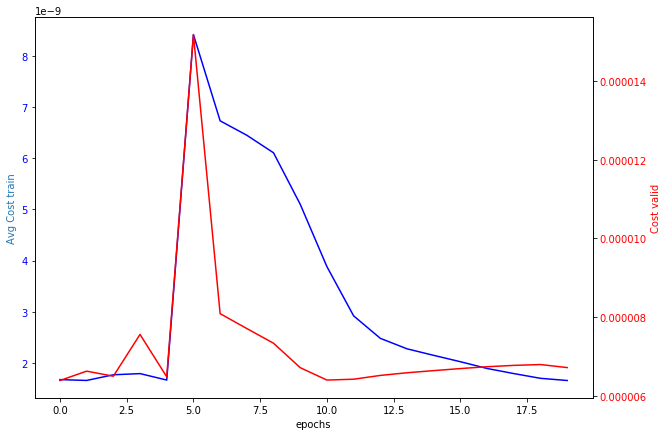

In [29]:
# Plot the costs
fig, ax1 = plt.subplots(figsize=(10, 7))
x = np.arange(nb_epoch)
ax1.plot(x, avg_cost_v, 'b-')
ax1.set_xlabel('epochs')
# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('Avg Cost train', color='C0')
for tl in ax1.get_yticklabels():
    tl.set_color('b')


ax2 = ax1.twinx()
ax2.plot(x, c_valid, 'r-')
ax2.set_ylabel('Cost valid', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')  
plt.show()

#### Learning rate through epochs

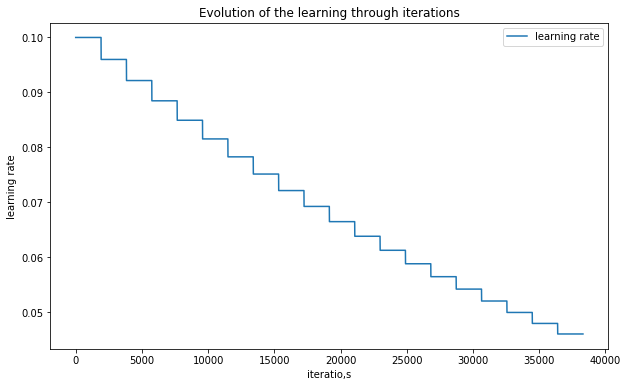

In [30]:
# Plot the learning rate
plt.figure(figsize=(10, 6))
plt.plot(l_rate_v, label="learning rate")
plt.legend(loc='best')
plt.ylabel('learning rate')
plt.xlabel('iteratio,s')
plt.title('Evolution of the learning through iterations')
plt.show()

#### Normalized predictions against normalized original values
Use to check whether the denormalization process is consistent

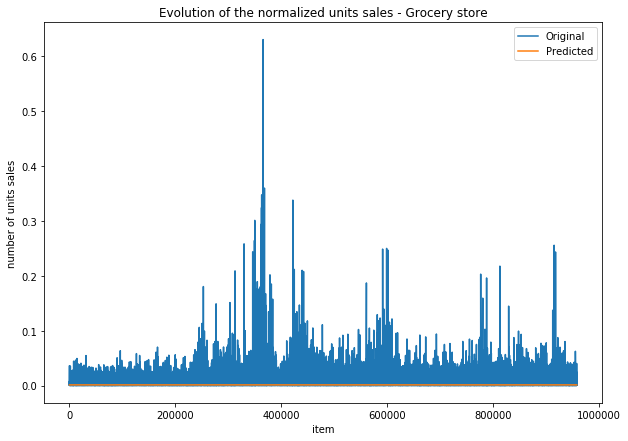

In [31]:
# Plot normalized predictions vs normalized original
fig = plt.figure(figsize=(10, 7))
plt.plot(y_test, label='Original')
plt.plot(pred_test_norm, label='Predicted')
plt.xlabel('item')
plt.ylabel('number of units sales')
plt.legend(loc='best')
plt.title('Evolution of the normalized units sales - Grocery store')
plt.show()

#### Predictions against original values

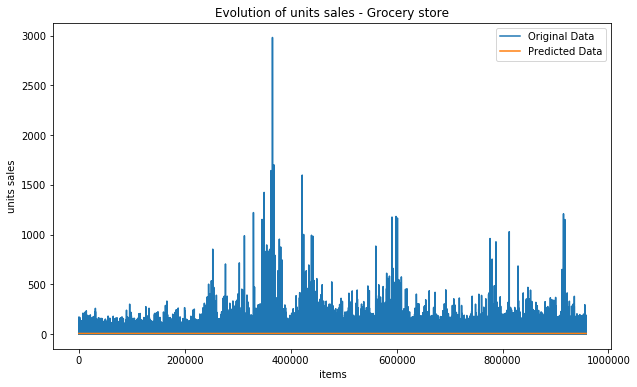

In [32]:
# Plot the prediction vs the original
plt.figure(figsize=(10, 6))
plt.plot(range(y_test.shape[0]), denormalize(data_y, y_test), label="Original Data")
plt.plot(range(y_test.shape[0]), pred_test, label="Predicted Data")
plt.legend(loc='best')
plt.ylabel('units sales')
plt.xlabel('items')
plt.title('Evolution of units sales - Grocery store')
plt.show()

#### Predictions only
Use to observe more precisely the predictions

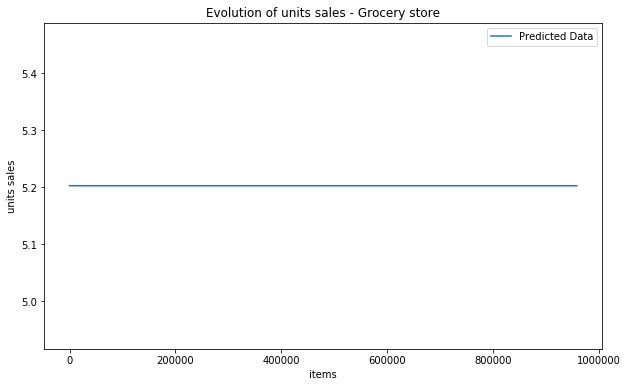

In [33]:
# Plot the prediction vs the original
plt.figure(figsize=(10, 6))
plt.plot(range(y_test.shape[0]), pred_test, label="Predicted Data")
plt.legend(loc='best')
plt.ylabel('units sales')
plt.xlabel('items')
plt.title('Evolution of units sales - Grocery store')
plt.show()

## VI - Reccurent neural network - Tensorflow

### A - Model initialization

#### Input data

In [34]:
# Dataset reshaped
X_train = data_X_norm[train_set, :]
y_train = data_y_norm[train_set]
X_valid = data_X_norm[valid_set, :]
y_valid = data_y_norm[valid_set]
X_test = data_X_norm[test_set, :]
y_test = data_y_norm[test_set]

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_valid = X_valid.reshape((X_valid.shape[0], 1, X_valid.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print('Train:')
print('----')
print(X_train.shape, y_train.shape)
print()
print('Valid:')
print('----')
print(X_valid.shape, y_valid.shape)
print()
print('Test:')
print('----')
print(X_test.shape, y_test.shape)

Train:
----
(1915537, 1, 36) (1915537, 1)

Valid:
----
(319256, 1, 36) (319256, 1)

Test:
----
(957769, 1, 36) (957769, 1)


#### Graph definition

In [35]:
# design network
model = Sequential()
model.add(LSTM(30, input_shape=(X_train.shape[1],
               X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

### B - Model training

In [36]:
# fit network
history = model.fit(X_train, y_train, epochs=15, batch_size=250,
                    validation_data=(X_valid, y_valid), verbose=1, shuffle=False)

Train on 1915537 samples, validate on 319256 samples
Epoch 1/15
1915537/1915537 [==============================] - 17s 9us/step - loss: 3.2828e-05 - val_loss: 6.9646e-06
Epoch 2/15
1915537/1915537 [==============================] - 16s 8us/step - loss: 1.3401e-05 - val_loss: 6.4070e-06
Epoch 3/15
1915537/1915537 [==============================] - 17s 9us/step - loss: 1.2558e-05 - val_loss: 6.3988e-06
Epoch 4/15
1915537/1915537 [==============================] - 18s 9us/step - loss: 1.2328e-05 - val_loss: 6.1039e-06
Epoch 5/15
1915537/1915537 [==============================] - 17s 9us/step - loss: 1.2298e-05 - val_loss: 6.0408e-06
Epoch 6/15
1915537/1915537 [==============================] - 17s 9us/step - loss: 1.2229e-05 - val_loss: 6.0125e-06
Epoch 7/15
1915537/1915537 [==============================] - 18s 9us/step - loss: 1.2160e-05 - val_loss: 5.9536e-06
Epoch 8/15
1915537/1915537 [==============================] - 18s 9us/step - loss: 1.2113e-05 - val_loss: 5.9469e-06
Epoch 9/15


#### Denormalize predictions

In [37]:
# make a prediction
yhat = model.predict(X_test)

# Rescale the prediction between 0 and 1 - Under scaled predictions
scaler_pred = MinMaxScaler(feature_range=(0, 1))
scaler_fitted_pred = scaler_pred.fit(np.abs(yhat))
yhat_scaled = scaler_fitted_pred.transform(np.abs(yhat))

# invert scaling for forecast & original
pred = denormalize(data_y, yhat_scaled)
real = denormalize(data_y, y_test)

#### Calcul de l'erreur

In [38]:
# calculate RMSE
rmse = np.sqrt(mean_squared_error(pred, real))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 126.133


### C - Visualization

#### Cost of the prediction

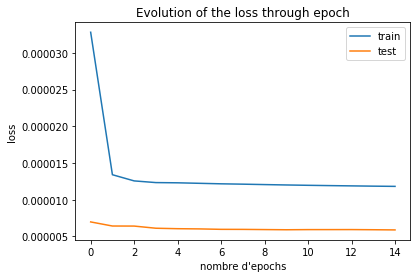

In [39]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Evolution of the loss through epoch')
plt.xlabel("nombre d'epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

#### Predictions against original values

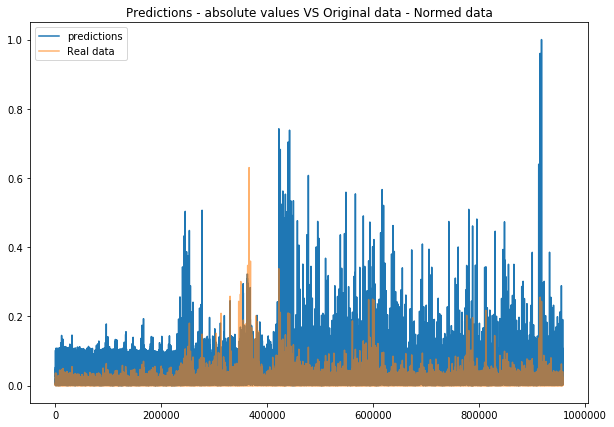

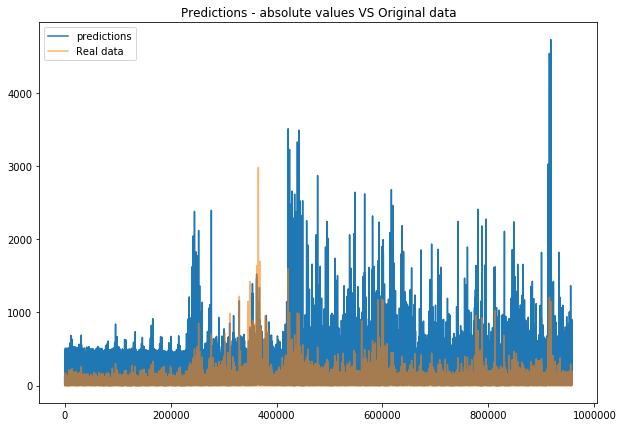

In [40]:
# Comparaison - Normed data
plt.figure(figsize=(10, 7))
plt.plot(yhat_scaled, label='predictions')
plt.plot(y_test, label='Real data', alpha=0.6)
plt.title('Predictions - absolute values VS Original data - Normed data')
plt.legend()
plt.show()

# Comparaison - Non-scaled data
plt.figure(figsize=(10, 7))
plt.plot(pred, label='predictions')
plt.plot(real, label='Real data', alpha=0.6)
plt.title('Predictions - absolute values VS Original data')
plt.legend()
plt.show()